**1. Selecting Dataset**

---





In [1]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#change directory
%%capture
%cd /content/gdrive/MyDrive/FYP - Team Nova

In [3]:
#list files in current directory
%ls

 answers.csv    'Discovery of User Expertise'/
 answers.csv.1  'Estimated Time of Answer'/
 answers.csv.2  'Question Difficulty Estimation'/
 answers.csv.3   save.pkl


**2. Importing Libraries**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
import xml.etree.ElementTree as ET
import csv
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import pickle

In [5]:
#downloading dataset into google drive
# !wget https://www.ics.uci.edu/~duboisc/stackoverflow/answers.csv

In [6]:
#read dataset into pandas dataframe
dataset = pd.read_csv('answers.csv').drop(['Unnamed: 0'],axis=1)
dataset

,qid,i,qs,qt,tags,qvc,qac,aid,j,as,at
0,563355,62701.0,0,1235000081,"php,error,gd,image-processing",220,2,563372,67183.0,2,1235000501
1,563355,62701.0,0,1235000081,"php,error,gd,image-processing",220,2,563374,66554.0,0,1235000551
2,563356,15842.0,10,1235000140,"lisp,scheme,subjective,clojure",1047,16,563358,15842.0,3,1235000177
3,563356,15842.0,10,1235000140,"lisp,scheme,subjective,clojure",1047,16,563413,893.0,18,1235001545
4,563356,15842.0,10,1235000140,"lisp,scheme,subjective,clojure",1047,16,563454,11649.0,4,1235002457
...,...,...,...,...,...,...,...,...,...,...,...
263535,961412,117069.0,0,1244359898,"c#,string-manipulation",26,2,961415,22656.0,2,1244360077
263536,961412,117069.0,0,1244359898,"c#,string-manipulation",26,2,961421,3712.0,1,1244360250
263537,961416,63225.0,2,1244360143,"ûnet,msil,history",42,2,961428,22656.0,2,1244360525
263538,961416,63225.0,2,1244360143,"ûnet,msil,history",42,2,961443,110945.0,0,1244361172


**3. Data Preprocessig**

---



In [7]:
#rename column headers
dataset = dataset.rename(columns={
                 'qid': 'QuestionId',
                 'aid' : 'AnswerId',
                 'i' : 'QuestionerId',
                 'j' : 'AnswererId',
                 'qt' : 'TimeOfQuestion',
                 'qs' : 'ScoreOfQuestion',
                 'tags': 'Tags',
                 'qvc': 'ViewCount',
                 'qac': 'NoOfAnswers',
                 'as' : 'ScoreOfAnswer',
                 'at' : 'TimeOfAnswer'
                 })

In [8]:
#show dataset
dataset

,QuestionId,QuestionerId,ScoreOfQuestion,TimeOfQuestion,Tags,ViewCount,NoOfAnswers,AnswerId,AnswererId,ScoreOfAnswer,TimeOfAnswer
0,563355,62701.0,0,1235000081,"php,error,gd,image-processing",220,2,563372,67183.0,2,1235000501
1,563355,62701.0,0,1235000081,"php,error,gd,image-processing",220,2,563374,66554.0,0,1235000551
2,563356,15842.0,10,1235000140,"lisp,scheme,subjective,clojure",1047,16,563358,15842.0,3,1235000177
3,563356,15842.0,10,1235000140,"lisp,scheme,subjective,clojure",1047,16,563413,893.0,18,1235001545
4,563356,15842.0,10,1235000140,"lisp,scheme,subjective,clojure",1047,16,563454,11649.0,4,1235002457
...,...,...,...,...,...,...,...,...,...,...,...
263535,961412,117069.0,0,1244359898,"c#,string-manipulation",26,2,961415,22656.0,2,1244360077
263536,961412,117069.0,0,1244359898,"c#,string-manipulation",26,2,961421,3712.0,1,1244360250
263537,961416,63225.0,2,1244360143,"ûnet,msil,history",42,2,961428,22656.0,2,1244360525
263538,961416,63225.0,2,1244360143,"ûnet,msil,history",42,2,961443,110945.0,0,1244361172


In [9]:
#remove unwanted columns
dataset = dataset.drop(columns=['QuestionerId','TimeOfQuestion','AnswererId','AnswerId','Tags'])
dataset.head()

,QuestionId,ScoreOfQuestion,ViewCount,NoOfAnswers,ScoreOfAnswer,TimeOfAnswer
0,563355,0,220,2,2,1235000501
1,563355,0,220,2,0,1235000551
2,563356,10,1047,16,3,1235000177
3,563356,10,1047,16,18,1235001545
4,563356,10,1047,16,4,1235002457


In [10]:
#find time and score of first answer by group by QuestionId
grouped_df = dataset.groupby('QuestionId')
minimums = grouped_df.min();
dataset = minimums.reset_index()
dataset.head()

,QuestionId,ScoreOfQuestion,ViewCount,NoOfAnswers,ScoreOfAnswer,TimeOfAnswer
0,563355,0,220,2,0,1235000501
1,563356,10,1047,16,0,1235000177
2,563365,0,108,3,0,1235000573
3,563366,0,179,1,1,1235003300
4,563367,0,247,2,1,1235056128


In [11]:
#Reanme column headers of time and score of first answer
dataset = dataset.rename(columns={
                 'TimeOfAnswer' : 'FirstResponseTimeToTheQuestion',
                 'ScoreOfAnswer' : 'ScoreOfTheFirstAnswer'
                 })
dataset.head()

,QuestionId,ScoreOfQuestion,ViewCount,NoOfAnswers,ScoreOfTheFirstAnswer,FirstResponseTimeToTheQuestion
0,563355,0,220,2,0,1235000501
1,563356,10,1047,16,0,1235000177
2,563365,0,108,3,0,1235000573
3,563366,0,179,1,1,1235003300
4,563367,0,247,2,1,1235056128


In [12]:
#feature list
features = ['ScoreOfQuestion','ViewCount','NoOfAnswers','ScoreOfTheFirstAnswer','FirstResponseTimeToTheQuestion']

In [13]:
#get dataset only with features
dataset = dataset[features]

In [14]:
#show dataset
dataset.head()

,ScoreOfQuestion,ViewCount,NoOfAnswers,ScoreOfTheFirstAnswer,FirstResponseTimeToTheQuestion
0,0,220,2,0,1235000501
1,10,1047,16,0,1235000177
2,0,108,3,0,1235000573
3,0,179,1,1,1235003300
4,0,247,2,1,1235056128


3.2 Handling Missing values

---



In [15]:
#check for null values
null_columns = dataset.columns[dataset.isnull().any()]
sum(dataset[null_columns].isnull().sum())

0

In [16]:
#check for zero values
sum((dataset[["ViewCount","NoOfAnswers","FirstResponseTimeToTheQuestion"]]==0).sum())

0

In [17]:
#round first response time for the question
dataset['FirstResponseTimeToTheQuestion'] = dataset['FirstResponseTimeToTheQuestion'].div(10000000).round(2)
dataset.head()

,ScoreOfQuestion,ViewCount,NoOfAnswers,ScoreOfTheFirstAnswer,FirstResponseTimeToTheQuestion
0,0,220,2,0,123.50
1,10,1047,16,0,123.50
2,0,108,3,0,123.50
3,0,179,1,1,123.50
4,0,247,2,1,123.51


In [18]:
#show dataset
dataset.head()

,ScoreOfQuestion,ViewCount,NoOfAnswers,ScoreOfTheFirstAnswer,FirstResponseTimeToTheQuestion
0,0,220,2,0,123.50
1,10,1047,16,0,123.50
2,0,108,3,0,123.50
3,0,179,1,1,123.50
4,0,247,2,1,123.51


Studying about the data distribution for extracted features

---



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


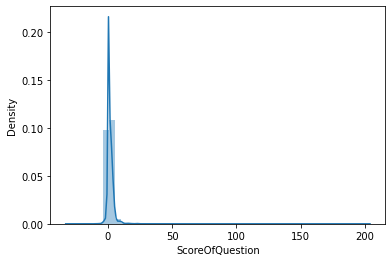

In [19]:
#score of question
x = dataset['ScoreOfQuestion']
ax = sns.distplot(x)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


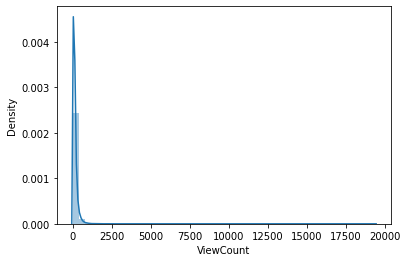

In [20]:
#view count
x = dataset['ViewCount']
ax = sns.distplot(x)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


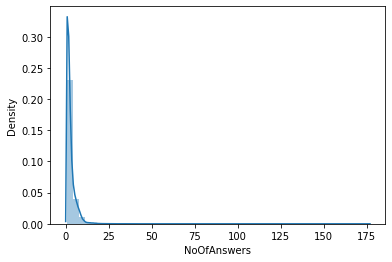

In [21]:
#no of answers
x = dataset['NoOfAnswers']
ax = sns.distplot(x)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


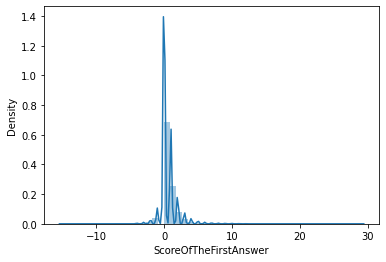

In [22]:
#score of first answer
x = dataset['ScoreOfTheFirstAnswer']
ax = sns.distplot(x)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


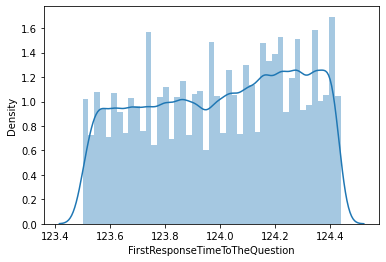

In [23]:
#first response time to the question
x = dataset['FirstResponseTimeToTheQuestion']
ax = sns.distplot(x)

**4. Extract Proportionately proportional, Inversely proportional features**

---



In [24]:
#find Proportionately_proportional and Inversely_proportional features
dataset['Proportionately_proportional']=dataset['ScoreOfQuestion']+ 2*dataset['FirstResponseTimeToTheQuestion']
dataset['Inversely_proportional']=2*dataset['NoOfAnswers']+dataset['ScoreOfTheFirstAnswer']+3*dataset['ViewCount']
dataset.head()

,ScoreOfQuestion,ViewCount,NoOfAnswers,ScoreOfTheFirstAnswer,FirstResponseTimeToTheQuestion,Proportionately_proportional,Inversely_proportional
0,0,220,2,0,123.50,247.00,664
1,10,1047,16,0,123.50,257.00,3173
2,0,108,3,0,123.50,247.00,330
3,0,179,1,1,123.50,247.00,540
4,0,247,2,1,123.51,247.02,746


In [25]:
#get final feature dataset
dataset = dataset[['Proportionately_proportional','Inversely_proportional']]

**5. Devide dataset into training and test sets**

---



In [26]:
#devide dataset into test and train datasets
x_train, x_test= train_test_split(dataset,test_size=0.2,random_state=0)

In [27]:
#show x_train
x_train

,Proportionately_proportional,Inversely_proportional
8458,253.22,1338
57110,248.36,174
82879,248.84,148
4517,247.12,232
25981,247.64,270
...,...,...
21243,248.52,243
45891,248.12,369
42613,250.06,622
43567,250.08,858


In [28]:
#show x_test
x_test

,Proportionately_proportional,Inversely_proportional
81847,250.84,152
15292,247.38,1141
13967,248.86,89
32019,251.80,219
11740,249.30,916
...,...,...
18214,252.46,770
19827,250.50,1441
10561,247.60,1034
58051,252.36,1102


In [29]:
#get x_test as array
X_TEST = x_test.values
X_TEST

array([[ 250.84,  152.  ],
       [ 247.38, 1141.  ],
       [ 248.86,   89.  ],
       ...,
       [ 247.6 , 1034.  ],
       [ 252.36, 1102.  ],
       [ 248.48,  270.  ]])

In [30]:
#get x_test as array
X_TRAIN = x_train.values
X_TRAIN

array([[ 253.22, 1338.  ],
       [ 248.36,  174.  ],
       [ 248.84,  148.  ],
       ...,
       [ 250.06,  622.  ],
       [ 250.08,  858.  ],
       [ 248.58,  309.  ]])

**6. Define kmeans clustering model**

---



In [31]:
#define k_means clustering model for 5 clusters
def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

**7. Finding the optimal number of clusters**

---



**7.1 Elbow Method**

---



In [ ]:
distortions = []
k_means_models = []
for i in range(2, 9):
  km_obj, clusters = k_means(feature_matrix=X_TRAIN,num_clusters=i)
  distortions.append(km_obj.inertia_)
  k_means_models.append(km_obj)

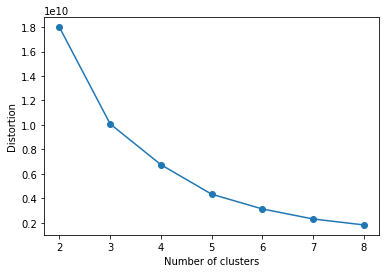

In [ ]:
plt.plot(range(2, 9), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

**7.2 Average silhouette method**

---



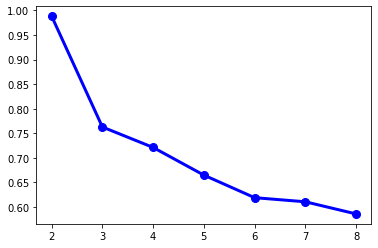

In [ ]:
silhouette_scores = [silhouette_score(X_TRAIN ,model.labels_) for model in k_means_models]
_ = plt.plot(range(2,9), silhouette_scores, "bo-", color='blue',linewidth=3,markersize=8)

For n_clusters = 2 The average silhouette_score is : 0.9862111684039555
For n_clusters = 3 The average silhouette_score is : 0.7624163448783955
For n_clusters = 4 The average silhouette_score is : 0.7237806711234874
For n_clusters = 5 The average silhouette_score is : 0.664950029751527
For n_clusters = 6 The average silhouette_score is : 0.6325665490414765


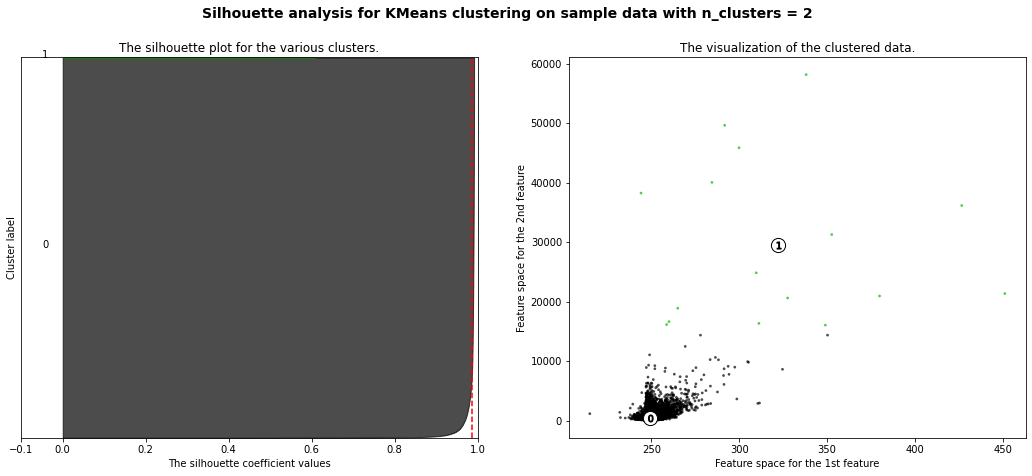

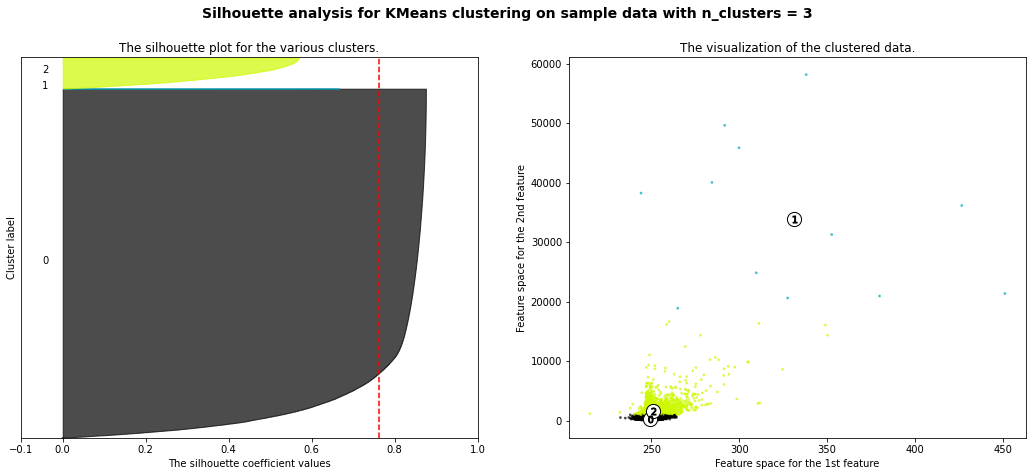

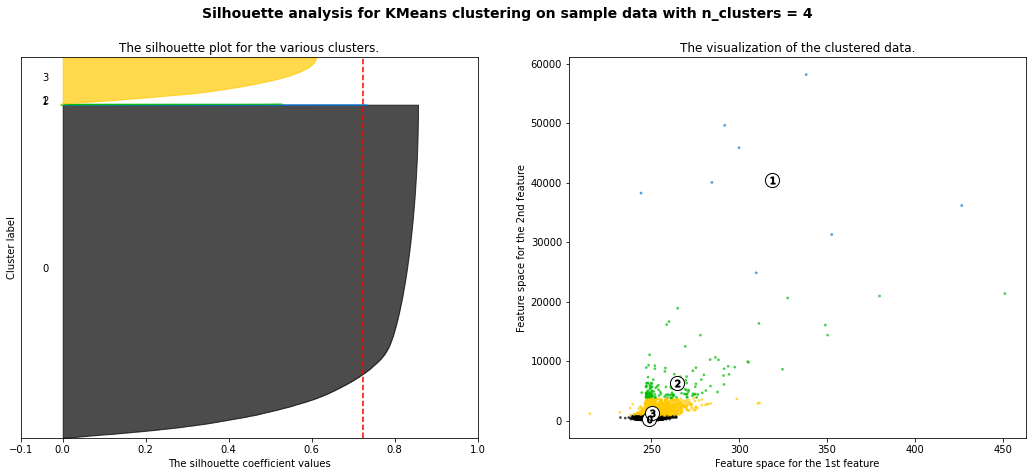

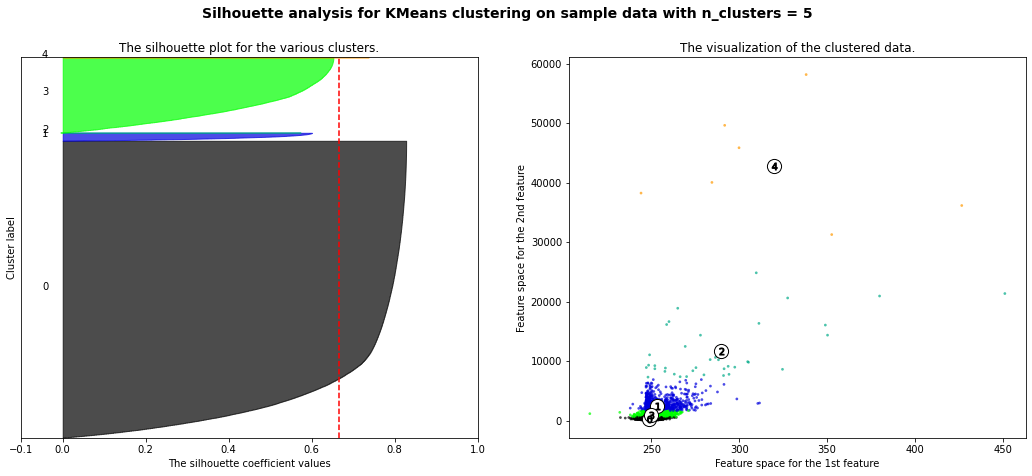

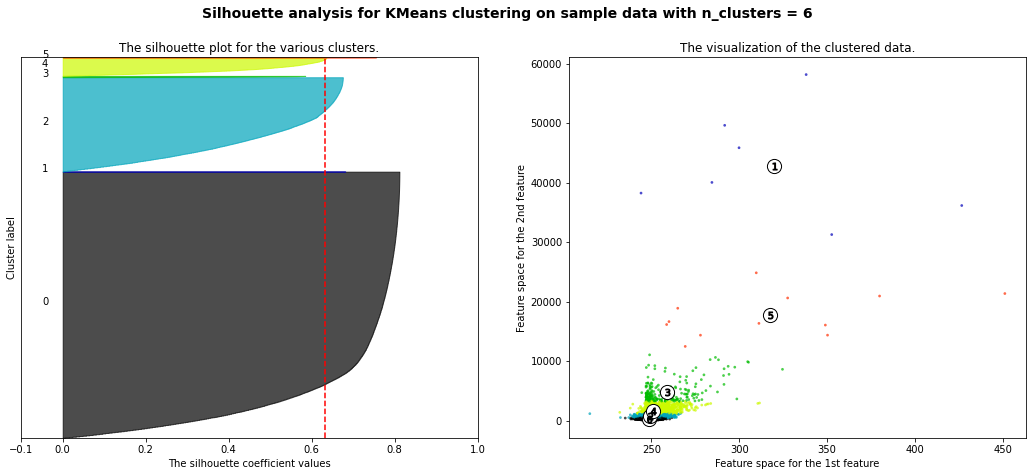

In [ ]:
range_n_clusters = [2, 3, 4, 5, 6]
 
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
 
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X_TRAIN) + (n_clusters + 1) * 10])
 
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_TRAIN)
 
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_TRAIN, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
 
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_TRAIN, cluster_labels)
 
    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
 
        ith_cluster_silhouette_values.sort()
 
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
 
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
 
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
 
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
 
    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
 
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
 
    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_TRAIN[:, 0], X_TRAIN[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
 
    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
 
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
 
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
 
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
 
plt.show()

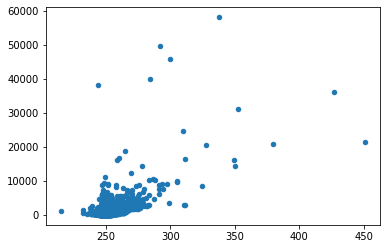

In [ ]:
plt.scatter(X_TRAIN[:, 0], X_TRAIN[:, 1], s=20);
plt.show()

**8. Training the K-means algorithm on the training dataset**

---



In [32]:
kmeans_model = KMeans(n_clusters = 3,  init= 'k-means++', max_iter= 100000).fit(X_TRAIN)
labels = kmeans_model.labels_
y_kmeans = kmeans_model.predict(X_TRAIN)
x_train['Cluster'] = labels
def ClusterLabel(x,y):
  if x == 0:
      return "Basic"
  elif x == 1:
      return "Advanced"
  elif x == 2:
      return "Intermediate"   
x_train['Cluster_Label'] = x_train['Cluster'].apply(ClusterLabel, args=('Cluster',))
x_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Proportionately_proportional,Inversely_proportional,Cluster,Cluster_Label
8458,253.22,1338,2,Intermediate
57110,248.36,174,0,Basic
82879,248.84,148,0,Basic
4517,247.12,232,0,Basic
25981,247.64,270,0,Basic
...,...,...,...,...
21243,248.52,243,0,Basic
45891,248.12,369,0,Basic
42613,250.06,622,0,Basic
43567,250.08,858,0,Basic


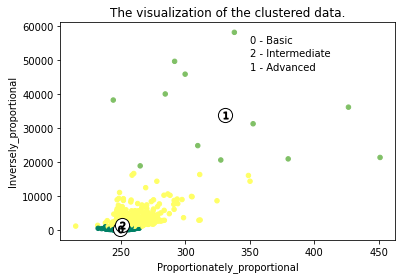

In [33]:
#visualization of the clustered data
plt.scatter(X_TRAIN[:, 0], X_TRAIN[:, 1], c=y_kmeans, s=20, cmap='summer')
centers = kmeans_model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k');
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    plt.title("The visualization of the clustered data.")
    plt.xlabel("Proportionately_proportional")
    plt.ylabel("Inversely_proportional")
plt.text(350, 55000, r'0 - Basic')
plt.text(350, 51000, r'2 - Intermediate')
plt.text(350, 47000, r'1 - Advanced')
plt.show()

**9. Save model and Predict difficulty level of test dataset by model**

---



In [34]:
#save model
pickle.dump(kmeans_model, open("save.pkl", "wb"))

In [35]:
#load model
model_ = pickle.load(open("save.pkl", "rb"))

In [36]:
# Predict difficulty level of test dataset by model
t = X_TEST
v = model_.predict(t)
x_test['Cluster'] = v
def ClusterLabel(x,y):
  if x == 0:
      return "Basic"
  elif x == 1:
      return "Advanced"
  elif x == 2:
      return "Intermediate"   
x_test['Cluster_Label'] = x_test['Cluster'].apply(ClusterLabel, args=('Cluster',))
x_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Proportionately_proportional,Inversely_proportional,Cluster,Cluster_Label
81847,250.84,152,0,Basic
15292,247.38,1141,2,Intermediate
13967,248.86,89,0,Basic
32019,251.80,219,0,Basic
11740,249.30,916,0,Basic
...,...,...,...,...
18214,252.46,770,0,Basic
19827,250.50,1441,2,Intermediate
10561,247.60,1034,2,Intermediate
58051,252.36,1102,2,Intermediate


**10. Cluster Evaluation**

---



In [37]:
#Evaluation cluster by silhouette score
silhouette_score(X_TRAIN, labels, metric = 'euclidean')

0.7624163448783955

**11. Creating Api for model**

---



In [38]:
#install fastapi library
!pip install fastapi

In [39]:
#create question model
from pydantic import BaseModel

class Question(BaseModel):
    ScoreOfQuestion: float 
    ViewCount: float 
    NoOfAnswers: float 
    ScoreOfTheFirstAnswer: float
    FirstResponseTimeToTheQuestion: float 
    class Config:
        schema_extra = {
            "example": {
                "ScoreOfQuestion": 20, 
                "ViewCount": 1000,
                "NoOfAnswers": 6, 
                "ScoreOfTheFirstAnswer":50,             
                "FirstResponseTimeToTheQuestion": 1230000
            }
        }

In [40]:
#create app
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import pickle

app = FastAPI()

origins = [

    "http://localhost.tiangolo.com",

    "https://localhost.tiangolo.com",

    "http://localhost:4200",

    "http://localhost:8080",

]

app.add_middleware(

    CORSMiddleware,

    allow_origins=origins,

    allow_credentials=True,

    allow_methods=["*"],

    allow_headers=["*"],

)

@app.on_event("startup")
def load_model():
    global model
    model = pickle.load(open("save.pkl", "rb"))

@app.get('/')
def index():
    return {'message': 'This is the homepage of the API '}

@app.post('/predict')
def get_question_difficulty(data: Question):
    received = data.dict()

    ScoreOfQuestion = received['ScoreOfQuestion']
    ViewCount = received['ViewCount']
    NoOfAnswers = received['NoOfAnswers']
    ScoreOfTheFirstAnswer = received['ScoreOfTheFirstAnswer']
    FirstResponseTimeToTheQuestion = received['FirstResponseTimeToTheQuestion']/10000000

    Proportionately_proportional=ScoreOfQuestion+2*FirstResponseTimeToTheQuestion
    Inversely_proportional=ScoreOfTheFirstAnswer+2*NoOfAnswers+3*ViewCount

    pred_difficulty_level = model.predict([[Proportionately_proportional, Inversely_proportional]]).tolist()[0]
    if pred_difficulty_level == 0:
      return {'difficulty_level': 'Basic'}
    elif pred_difficulty_level == 1:
      return {'difficulty_level': 'Advanced'}
    else:
      return {'difficulty_level': 'Intermediate'}

    

In [41]:
#upgrade notebook
!pip install --upgrade notebook

Requirement already up-to-date: notebook in /usr/local/lib/python3.7/dist-packages (6.4.0)


In [42]:
#install colab code
!pip install colabcode

In [43]:
#create server
from colabcode import ColabCode
server = ColabCode(port=10000, code=False)

In [2]:
#run server
server.run_app(app=app)

NameError: ignored